In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, DensityMixin

POI_FILENAME = r"C:/Users/titouan/OneDrive/Bureau/SORBONNE S2/ML/TME/tme2/data/poi-paris.pkl"
parismap = mpimg.imread(r'C:/Users/titouan/OneDrive/Bureau/SORBONNE S2/ML/TME/tme2/data/paris-48.806-2.23--48.916-2.48.jpg')
## coordonnees GPS de la carte
xmin, xmax = 2.23, 2.48  # coord_x min et max
ymin, ymax = 48.806, 48.916  # coord_y min et max
coords = [xmin, xmax, ymin, ymax]

In [39]:
class Density(object):
    def fit(self,data):
        pass
    def predict(self,data):
        pass
    def score(self,data):
        #A compléter : retourne la log-vraisemblance
        prediction = self.predict(data)
        new_data = np.where(prediction==0, 10**-10, prediction) #if data == 0 put small val else data
        return np.log(new_data).sum()


class Histogramme(Density, BaseEstimator, DensityMixin): #seul moyen pour que ce soit compatiible avec le cross validation
    def __init__(self,steps=10):
        Density.__init__(self)
        self.steps = steps
        self.density = None
        self.edges = None

    def to_bin(self, x, index):
        indice = np.searchsorted(self.edges[index], x) 
        return np.clip(indice - 1, 0, len(self.edges[index]) - 2)
    
    def fit(self,x, y=None):
        #A compléter : apprend l'histogramme de la densité sur x
        self.density, self.edges = np.histogramdd(x, bins=self.steps, density=True)
        return self
        
    def predict(self,x):
        #A compléter : retourne la densité associée à chaque point de x
        return self.density[self.to_bin(x[:,0], 0), self.to_bin(x[:,1], 1)]

class KernelDensity(Density):
    def __init__(self,kernel=None,sigma=0.1):
        Density.__init__(self)
        self.kernel = kernel
        self.sigma = sigma
    def fit(self,x):
        self.x = x
    def predict(self,data):
        #A compléter : retourne la densité associée à chaque point de data
        pass

In [40]:
def get_density2D(f,data,steps=100):
    """ Calcule la densité en chaque case d'une grille steps x steps dont les bornes sont calculées à partir du min/max de data. Renvoie la grille estimée et la discrétisation sur chaque axe.
    """
    xmin, xmax = data[:,0].min(), data[:,0].max()
    ymin, ymax = data[:,1].min(), data[:,1].max()
    xlin,ylin = np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps)
    xx, yy = np.meshgrid(xlin,ylin)
    grid = np.c_[xx.ravel(), yy.ravel()]
    res = f.predict(grid).reshape(steps, steps)
    return res, xlin, ylin

def show_density(f, bins, data, steps=100, log=False):
    """ Dessine la densité f et ses courbes de niveau sur une grille 2D calculée à partir de data, avec un pas de discrétisation de steps. Le paramètre log permet d'afficher la log densité plutôt que la densité brute
    """
    res, xlin, ylin = get_density2D(f, data, steps)
    xx, yy = np.meshgrid(xlin, ylin)
    plt.figure()
    plt.title(f"bins:{bins} score:{f.score(data)}")
    show_img()
    if log:
        res = np.log(res+1e-10)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.8, s=3)
    show_img(res)
    plt.colorbar()
    plt.contour(xx, yy, res, 20)


def show_img(img=parismap):
    """ Affiche une matrice ou une image selon les coordonnées de la carte de Paris.
    """
    origin = "lower" if len(img.shape) == 2 else "upper"
    alpha = 0.3 if len(img.shape) == 2 else 1.
    plt.imshow(img, extent=coords, aspect=1.5, origin=origin, alpha=alpha)
    ## extent pour controler l'echelle du plan


def load_poi(typepoi,fn=POI_FILENAME):
    """ Dictionaire POI, clé : type de POI, valeur : dictionnaire des POIs de ce type : (id_POI, [coordonnées, note, nom, type, prix])
    
    Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, 
    clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
    """
    poidata = pickle.load(open(fn, "rb"))
    data = np.array([[v[1][0][1],v[1][0][0]] for v in sorted(poidata[typepoi].items())])
    note = np.array([v[1][1] for v in sorted(poidata[typepoi].items())])
    return data,note

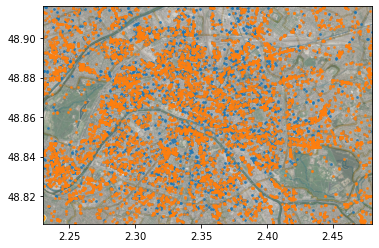

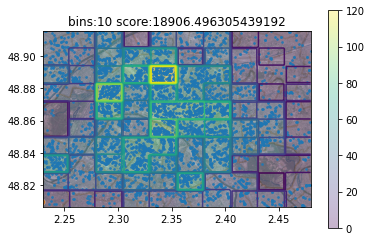

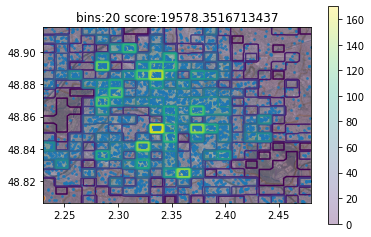

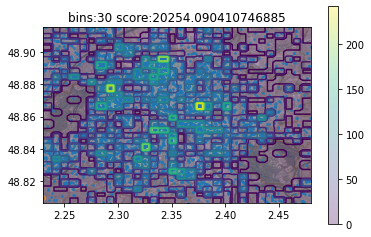

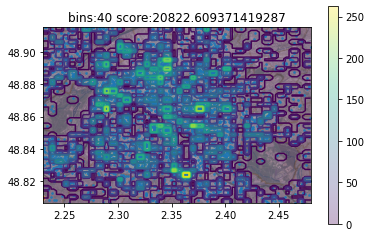

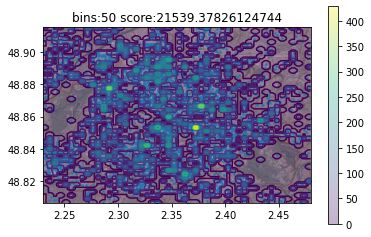

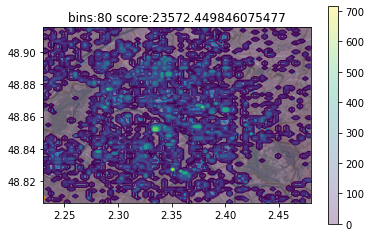

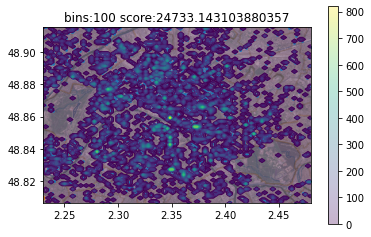

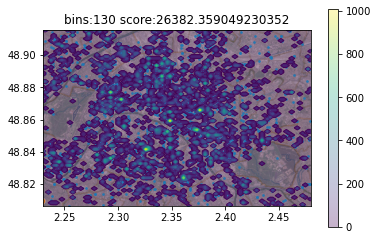

In [41]:
plt.ion()
# Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
# La fonction charge la localisation des POIs dans geo_mat et leur note.
geo_mat, notes = load_poi("bar")
geo_rest, notes_rest = load_poi("restaurant")


# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.scatter(geo_rest[:,0],geo_rest[:,1],alpha=0.8,s=3)

for s in [10,20,30,40,50,80,100,130]:
    histogram = Histogramme(steps=s)
    histogram.fit(geo_mat)
    #histogram.predict(geo_mat)
    show_density(histogram, s, geo_mat, steps=100)
    #print(get_density2D(histogram, geo_mat))


best step:17


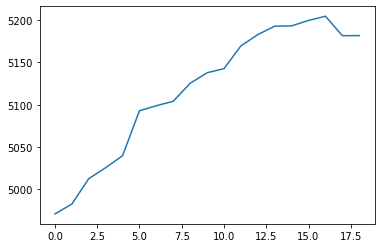

In [42]:
""" RESTAURANT POI """
avg = []
all_steps = []
for step in range(1,20):
    data, notes = load_poi("restaurant")
    histo = Histogramme(steps=step)
    score_list = cross_val_score(histo, data)
    avg.append(np.mean(score_list))
    all_steps.append(step)
print(f"best step:{all_steps[np.argmax(avg)]}")
plt.plot(avg)

best step:5


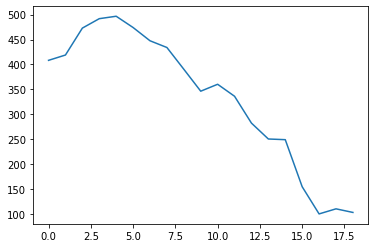

In [43]:
""" NIGHT CLUB POI """
avg = []
all_steps = []
for step in range(1,20):
    data, notes = load_poi("night_club")
    histo = Histogramme(steps=step)
    score_list = cross_val_score(histo, data)
    avg.append(np.mean(score_list))
    all_steps.append(step)
print(f"best step:{all_steps[np.argmax(avg)]}")
plt.plot(avg)

On voit bien ici que un POI plus rare necessite un plus petit nombre de bins dans chaque dimension car sont ont mets plus de bins il est possible qu'on se retrouve avec des trous dans notre histogramme. Avec un POI plus commun comme resturant on peu avoir plus de bins car il y a moins de chance d'avoir des trous.

In [44]:
""" METHODES A NOYAUX """

def kernel_uniform(x):
    for i in range(len(x)):
        if np.abs(x[i]) >= 0.5:
            return 0        
    return 1

def kernel_gaussian(x):
    return (2*np.pi)**(-len(x)/2)*np.exp(-0.5 * (np.linalg.norm(x)**2))